# Homework 3

Name: Stanly Gomes

Student ID: 801118166

GitHub Repository: https://github.com/NaraPvP/RealTimeML

In [1]:
# import libraries
from tqdm import tqdm
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split, Subset

import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from ptflops import get_model_complexity_info

import torchvision
from torchvision import transforms, datasets
from torchmetrics.classification import MulticlassAccuracy, BinaryAccuracy
from torchmetrics import ConfusionMatrix
from datetime import datetime

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Import Datasets
cifar_trainset = datasets.CIFAR10(root='./data',
                                  train=True,
                                  download=True,
                                  transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Resize(size=64),
                                    transforms.Normalize((0.4734), (0.2453))
                                    ])
)
cifar_testset = datasets.CIFAR10(root='./data',
                                 train=False,
                                 download=True,
                                 transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Resize(size=64),
                                    transforms.Normalize((0.4734), (0.2453))
                                    ])
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
image, label = cifar_trainset[0]
image.shape

torch.Size([3, 64, 64])

In [5]:
# Seperate train and val sets
cifar_train, cifar_val = random_split(cifar_trainset, [0.8, 0.2])
trainLoader = DataLoader(cifar_train, batch_size=32, shuffle=True)
valLoader = DataLoader(cifar_val, batch_size=32, shuffle=False)
testLoader = DataLoader(cifar_testset, batch_size=32, shuffle=False)

In [6]:
# # Find mean and std for normalization
# loader = DataLoader(cifar_trainset, batch_size=len(cifar_trainset), num_workers=1)
# data = next(iter(loader))
# data[0].mean(), data[0].std()

In [7]:
# Define train_step function
def train_step(model: nn.Module,
               data_loader: DataLoader,
               loss_fn: nn.Module,
               optim: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device):
    """Performs training step on a dataloader batch"""
    train_loss, train_acc = 0, 0
    model.train()
    for batch, (x, y) in enumerate(data_loader):
        # Move data to device
        x, y = x.to(device), y.to(device)
        
        # Forward pass (outputs log likelihood for each class)
        y_pred = model(x)
        # Calculate Loss/Acc of batch
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        # argmax is used to convert from log likelihood to prediction labels
        
        # Zero the gradience for optimizer
        optim.zero_grad()
        
        # Backpropagate loss
        loss.backward()
        
        # Step optimizer based on loss
        optim.step()
        
        acc = accuracy_fn(y_pred.argmax(dim=1), y)
        train_acc += acc.item()
        
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    return train_loss, train_acc

In [8]:
# Define val_step function
def val_step(model: nn.Module,
             data_loader: DataLoader,
             loss_fn: nn.Module,
             accuracy_fn,
             device: torch.device):
    """Performs validation step on val dataloader"""
    val_loss, val_acc = 0, 0
    model.eval()
    
    # Turn on inference mode context manager (increases speed)
    with torch.inference_mode():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            # Forward pass
            val_pred = model(x)
            
            # Calculate loss
            loss = loss_fn(val_pred, y)
            val_loss += loss.item()
            
            acc = accuracy_fn(val_pred.argmax(dim=1), y)
            val_acc += acc.item()
            
        val_loss /= len(data_loader)
        val_acc /= len(data_loader)
        return val_loss, val_acc

In [9]:
# Create train function
def train(model: nn.Module,
          train_dataloader: DataLoader,
          val_dataloader: DataLoader,
          optim: torch.optim.Optimizer,
          loss_fn: nn.Module,
          accuracy_fn,
          epochs: int,
          device: torch.device,
          verbose = False):
    results = {"Train Loss": [],
               "Train Accuracy": [],
               "Val Loss": [],
               "Val Accuracy": []}
    for epoch in tqdm(range(epochs), disable=verbose):
        train_loss, train_acc = train_step(model=model,
                                           data_loader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optim=optim,
                                           accuracy_fn=accuracy_fn,
                                           device=device)
        val_loss, val_acc = val_step(model=model,
                                     data_loader=val_dataloader,
                                     loss_fn=loss_fn,
                                     accuracy_fn=accuracy_fn,
                                     device=device)
        
        print(f"Epoch: {epoch+1}\n--------------- "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Accuracy: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {val_acc:.4f}"
             )
        results["Train Loss"].append(train_loss)
        results["Train Accuracy"].append(train_acc)
        results["Val Loss"].append(val_loss)
        results["Val Accuracy"].append(val_acc)
    return results

In [10]:
def print_train_time(start, end, device: torch.device=None):
    total_time = end - start
    print(f"{device} Training Time: {total_time:.3f} seconds")
    return total_time

In [11]:
# Plot history
from typing import Tuple, Dict, List
def plot_history(results: Dict[str, List[float]]):
    loss = results["Train Loss"]
    val_loss = results["Val Loss"]
    acc = results["Train Accuracy"]
    val_acc = results["Val Accuracy"]
    
    epochs = range(len(results["Train Loss"]))
    
    plt.figure()
    # Plot loss and accuracy
    plt.plot(epochs, loss, label="Train Loss")
    plt.plot(epochs, acc, label="Train Accuracy")
    plt.plot(epochs, val_acc, label="Val Accuracy")
    plt.title("Model History")
    plt.xlabel("Epochs")
    plt.legend()

## Problem 1a: Train baseline VGG on CIFAR-10 with 64x64 input resolution

In [28]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [29]:
class VGG_base(nn.Module):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        conv_blocks = []
        for (num_convs, out_channels) in arch:
            conv_blocks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blocks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes)
        )
    def forward(self, x):
        x = self.net(x)
        return x

In [58]:
P1a_model = VGG_base(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))).to(device)

In [35]:
from datetime import datetime

Epoch: 1
--------------- Train Loss: 2.3023, Train Accuracy: 0.0990, Val Loss: 2.2393, Val Accuracy: 0.1734
Epoch: 2
--------------- Train Loss: 2.2147, Train Accuracy: 0.1409, Val Loss: 1.9181, Val Accuracy: 0.2384
Epoch: 3
--------------- Train Loss: 1.7457, Train Accuracy: 0.3210, Val Loss: 1.7039, Val Accuracy: 0.3653
Epoch: 4
--------------- Train Loss: 1.4494, Train Accuracy: 0.4463, Val Loss: 1.2411, Val Accuracy: 0.5309
Epoch: 5
--------------- Train Loss: 1.1665, Train Accuracy: 0.5665, Val Loss: 1.0127, Val Accuracy: 0.6194
Epoch: 6
--------------- Train Loss: 0.9445, Train Accuracy: 0.6461, Val Loss: 0.9026, Val Accuracy: 0.6626
Epoch: 7
--------------- Train Loss: 0.7603, Train Accuracy: 0.7110, Val Loss: 0.7700, Val Accuracy: 0.7160
Epoch: 8
--------------- Train Loss: 0.6035, Train Accuracy: 0.7643, Val Loss: 0.7744, Val Accuracy: 0.7179
Epoch: 9
--------------- Train Loss: 0.4816, Train Accuracy: 0.8054, Val Loss: 0.7180, Val Accuracy: 0.7369
Epoch: 10
--------------- Tr

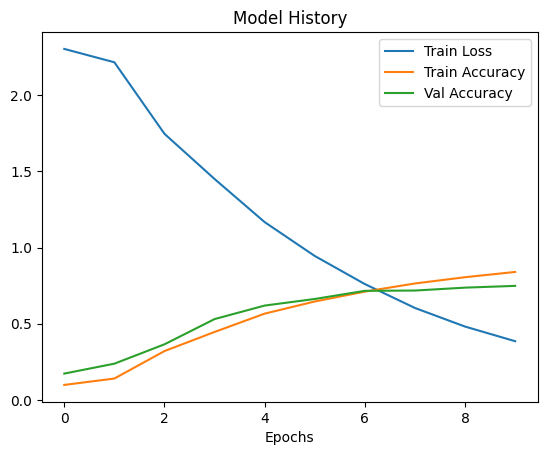

In [60]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=P1a_model.parameters(),
                            lr=0.1)
accuracy_fn = MulticlassAccuracy(num_classes=10).to(device)
epochs = 10

start_time = datetime.now()

P1a_model_history = train(model=P1a_model,
                         train_dataloader=trainLoader,
                         val_dataloader=valLoader,
                         optim=optimizer,
                         loss_fn=loss_fn,
                         accuracy_fn=accuracy_fn,
                         epochs=epochs,
                         device=device,
                         verbose=True)
stop_time = datetime.now()
print(f"Training Time: {stop_time - start_time}")
plot_history(P1a_model_history)

In [61]:
# Adding batch normalization to Problem 1a
def vgg_block_bn(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.LazyBatchNorm2d())
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)
class VGG_base_bn(nn.Module):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        conv_blocks = []
        for (num_convs, out_channels) in arch:
            conv_blocks.append(vgg_block_bn(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blocks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes)
        )
    def forward(self, x):
        x = self.net(x)
        return x

In [62]:
P1a_model_bn = VGG_base_bn(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))).to(device)

Epoch: 1
--------------- Train Loss: 1.6219, Train Accuracy: 0.4003, Val Loss: 1.2782, Val Accuracy: 0.5158
Epoch: 2
--------------- Train Loss: 1.1320, Train Accuracy: 0.6012, Val Loss: 0.9731, Val Accuracy: 0.6381
Epoch: 3
--------------- Train Loss: 0.8969, Train Accuracy: 0.6830, Val Loss: 1.0399, Val Accuracy: 0.6300
Epoch: 4
--------------- Train Loss: 0.7382, Train Accuracy: 0.7404, Val Loss: 0.9050, Val Accuracy: 0.6789
Epoch: 5
--------------- Train Loss: 0.6206, Train Accuracy: 0.7780, Val Loss: 0.7162, Val Accuracy: 0.7401
Epoch: 6
--------------- Train Loss: 0.5296, Train Accuracy: 0.8045, Val Loss: 0.6317, Val Accuracy: 0.7674
Epoch: 7
--------------- Train Loss: 0.4497, Train Accuracy: 0.8307, Val Loss: 0.7235, Val Accuracy: 0.7569
Epoch: 8
--------------- Train Loss: 0.3801, Train Accuracy: 0.8530, Val Loss: 0.6381, Val Accuracy: 0.7721
Epoch: 9
--------------- Train Loss: 0.3176, Train Accuracy: 0.8684, Val Loss: 0.5508, Val Accuracy: 0.8022
Epoch: 10
--------------- Tr

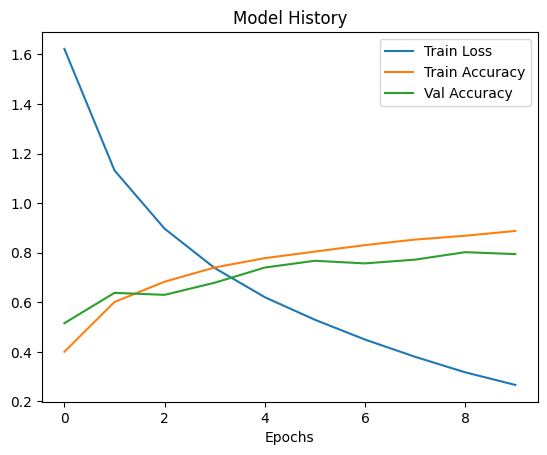

In [63]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=P1a_model_bn.parameters(),
                            lr=0.1)
accuracy_fn = MulticlassAccuracy(num_classes=10).to(device)
epochs = 10

start_time = datetime.now()
P1a_model_bn_history = train(model=P1a_model_bn,
                     train_dataloader=trainLoader,
                     val_dataloader=valLoader,
                     optim=optimizer,
                     loss_fn=loss_fn,
                     accuracy_fn=accuracy_fn,
                     epochs=epochs,
                     device=device,
                     verbose=True)
stop_time = datetime.now()
print(f"Training Time: {stop_time - start_time}")
plot_history(P1a_model_bn_history)

In [81]:
P1a_model_bn(torch.rand(1, 3, 64, 64).cuda())

tensor([[-0.8896, -2.8812,  1.3131,  2.7845,  3.7755, -0.2209,  0.9294, -0.9710,
         -1.5432, -2.0920]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
# CLEARED OUTPUT FOR SUBMISSION DUE TO LONG WARNING MESSAGE
# Obtain model size and complexity
# Ptflops Summary
from ptflops import get_model_complexity_info

with torch.cuda.device(0):
  macs, params = get_model_complexity_info(P1a_model_bn, (3, 64, 64), as_strings=True,
                                           print_per_layer_stat=False, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

In [139]:
# Save model weights
torch.save(P1a_model_bn.state_dict(), "models/P1a")

## Problem 1b: Use Table 1 in the VGG paper to construct other common models, such as VGG-16 or VGG-19. Train them on CIFAR-10, compare the accuracies, computational complexity and model size.

In [88]:
# Constructing VGG-16
P1b_16_arch =((2, 64), (2, 128), (3, 256), (3, 512), (3, 512))
P1b_16_model = VGG_base_bn(arch=P1b_16_arch).to(device)
P1b_16_model(torch.randn(1, 3, 64, 64).to(device))

tensor([[-0.3920, -0.0239, -0.4233, -0.1515, -0.4861, -0.1919,  0.4569, -0.4179,
         -0.1646,  0.1084]], device='cuda:0', grad_fn=<AddmmBackward0>)

 10%|████████▎                                                                          | 1/10 [01:01<09:13, 61.50s/it]

Epoch: 1
--------------- Train Loss: 1.7477, Train Accuracy: 0.3461, Val Loss: 1.5434, Val Accuracy: 0.4359


 20%|████████████████▌                                                                  | 2/10 [02:02<08:11, 61.50s/it]

Epoch: 2
--------------- Train Loss: 1.2074, Train Accuracy: 0.5689, Val Loss: 1.1730, Val Accuracy: 0.5686


 30%|████████████████████████▉                                                          | 3/10 [03:04<07:11, 61.68s/it]

Epoch: 3
--------------- Train Loss: 0.9157, Train Accuracy: 0.6815, Val Loss: 0.8213, Val Accuracy: 0.6975


 40%|█████████████████████████████████▏                                                 | 4/10 [04:06<06:10, 61.80s/it]

Epoch: 4
--------------- Train Loss: 0.7407, Train Accuracy: 0.7448, Val Loss: 0.8383, Val Accuracy: 0.7008


 50%|█████████████████████████████████████████▌                                         | 5/10 [05:08<05:08, 61.78s/it]

Epoch: 5
--------------- Train Loss: 0.6213, Train Accuracy: 0.7819, Val Loss: 0.8178, Val Accuracy: 0.7140


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [06:10<04:06, 61.75s/it]

Epoch: 6
--------------- Train Loss: 0.5271, Train Accuracy: 0.8095, Val Loss: 0.6143, Val Accuracy: 0.7753


 70%|██████████████████████████████████████████████████████████                         | 7/10 [07:12<03:05, 61.83s/it]

Epoch: 7
--------------- Train Loss: 0.4455, Train Accuracy: 0.8350, Val Loss: 0.6320, Val Accuracy: 0.7642


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [08:14<02:04, 62.05s/it]

Epoch: 8
--------------- Train Loss: 0.3849, Train Accuracy: 0.8508, Val Loss: 0.5014, Val Accuracy: 0.8102


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [09:17<01:02, 62.35s/it]

Epoch: 9
--------------- Train Loss: 0.3278, Train Accuracy: 0.8645, Val Loss: 0.5880, Val Accuracy: 0.7939


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [10:20<00:00, 62.04s/it]

Epoch: 10
--------------- Train Loss: 0.2734, Train Accuracy: 0.8880, Val Loss: 0.5027, Val Accuracy: 0.8206
Training Time: 0:10:20.450244


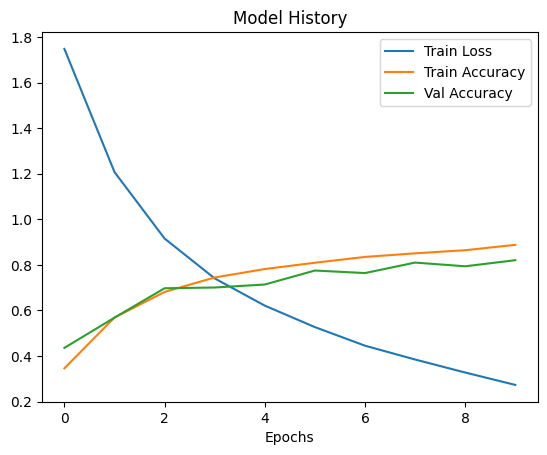

In [89]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=P1b_16_model.parameters(),
                            lr=0.1)
accuracy_fn = MulticlassAccuracy(num_classes=10).to(device)
epochs = 10

start_time = datetime.now()
P1b_16_model_history = train(model=P1b_16_model,
                     train_dataloader=trainLoader,
                     val_dataloader=valLoader,
                     optim=optimizer,
                     loss_fn=loss_fn,
                     accuracy_fn=accuracy_fn,
                     epochs=epochs,
                     device=device,
                     verbose=False)
stop_time = datetime.now()
print(f"Training Time: {stop_time - start_time}")
plot_history(P1b_16_model_history)

In [93]:
with torch.cuda.device(0):
  macs, params = get_model_complexity_info(P1b_16_model, (3, 64, 64), as_strings=True,
                                           print_per_layer_stat=False, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Computational complexity:       1.28 GMac
Number of parameters:           39.94 M 


In [140]:
torch.save(P1b_16_model.state_dict(), "models/P1b_16")

In [91]:
# Constructing VGG-19
P1b_19_arch = ((2, 64), (2, 128), (4, 256), (4, 512), (4, 512))
P1b_19_model = VGG_base_bn(arch=P1b_19_arch).to(device)
P1b_19_model(torch.randn(1, 3, 64, 64).to(device))

C:\Users\stanl\anaconda3\envs\pytorch_cuda\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


tensor([[ 0.2108, -0.2490, -0.0535, -0.0199, -0.2135,  0.0295,  0.1932, -0.2469,
          0.1599,  0.3199]], device='cuda:0', grad_fn=<AddmmBackward0>)

 10%|████████▎                                                                          | 1/10 [01:10<10:33, 70.37s/it]

Epoch: 1
--------------- Train Loss: 1.3699, Train Accuracy: 0.4984, Val Loss: 1.2392, Val Accuracy: 0.5515


 20%|████████████████▌                                                                  | 2/10 [02:22<09:29, 71.13s/it]

Epoch: 2
--------------- Train Loss: 1.0596, Train Accuracy: 0.6248, Val Loss: 0.9302, Val Accuracy: 0.6483


 30%|████████████████████████▉                                                          | 3/10 [03:32<08:16, 70.90s/it]

Epoch: 3
--------------- Train Loss: 0.8520, Train Accuracy: 0.7029, Val Loss: 0.8758, Val Accuracy: 0.6879


 40%|█████████████████████████████████▏                                                 | 4/10 [04:42<07:02, 70.35s/it]

Epoch: 4
--------------- Train Loss: 0.7136, Train Accuracy: 0.7502, Val Loss: 0.6924, Val Accuracy: 0.7455


 50%|█████████████████████████████████████████▌                                         | 5/10 [05:51<05:50, 70.03s/it]

Epoch: 5
--------------- Train Loss: 0.6024, Train Accuracy: 0.7863, Val Loss: 0.6586, Val Accuracy: 0.7588


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [07:01<04:39, 69.89s/it]

Epoch: 6
--------------- Train Loss: 0.5222, Train Accuracy: 0.8097, Val Loss: 0.6582, Val Accuracy: 0.7628


 70%|██████████████████████████████████████████████████████████                         | 7/10 [08:10<03:29, 69.80s/it]

Epoch: 7
--------------- Train Loss: 0.4528, Train Accuracy: 0.8315, Val Loss: 0.5628, Val Accuracy: 0.7969


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [09:20<02:19, 69.75s/it]

Epoch: 8
--------------- Train Loss: 0.3890, Train Accuracy: 0.8543, Val Loss: 0.6006, Val Accuracy: 0.7774


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [10:29<01:09, 69.61s/it]

Epoch: 9
--------------- Train Loss: 0.3387, Train Accuracy: 0.8662, Val Loss: 0.5436, Val Accuracy: 0.7999


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [11:38<00:00, 69.86s/it]

Epoch: 10
--------------- Train Loss: 0.2955, Train Accuracy: 0.8792, Val Loss: 0.5752, Val Accuracy: 0.7980
Training Time: 0:11:38.610347


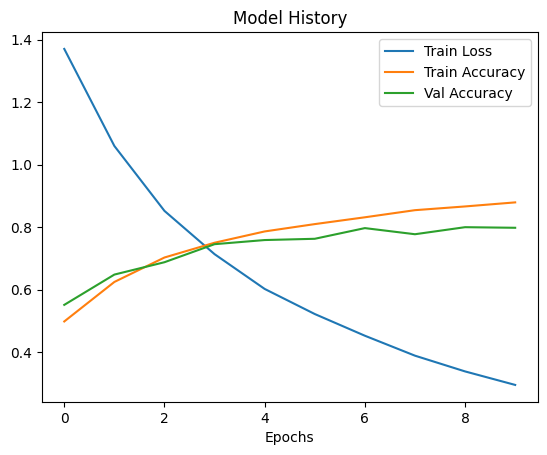

In [101]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=P1b_19_model.parameters(),
                            lr=0.1)
accuracy_fn = MulticlassAccuracy(num_classes=10).to(device)
epochs = 10

start_time = datetime.now()
P1b_19_model_history = train(model=P1b_19_model,
                     train_dataloader=trainLoader,
                     val_dataloader=valLoader,
                     optim=optimizer,
                     loss_fn=loss_fn,
                     accuracy_fn=accuracy_fn,
                     epochs=epochs,
                     device=device,
                     verbose=False)
stop_time = datetime.now()
print(f"Training Time: {stop_time - start_time}")
plot_history(P1b_19_model_history)

In [102]:
with torch.cuda.device(0):
  macs, params = get_model_complexity_info(P1b_19_model, (3, 64, 64), as_strings=True,
                                           print_per_layer_stat=False, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Computational complexity:       1.62 GMac
Number of parameters:           45.25 M 


In [141]:
torch.save(P1b_19_model.state_dict(), "models/P1b_19")

#### VGG_base model with Batch Norm:

Training time: 0:06:43.170907

Computation Complexity: 639.21 MMac

Number of parameters: 34.44 M

#### VGG-16 with Batch Norm:

Training time: 0:10:20.450244

Computational complexity: 1.28 GMac

Number of parameters: 39.94 M

#### VGG-19 with Batch Norm:

Training time: 0:11:38.610347

Computational complexity: 1.62 GMac

Number of parameters: 45.25 M

#### Conclusion:

When using the deeper VGG models, the accuracy increased and the generalization gap decreased further. If the models were trained for longer, there may have been a more significant difference in accuracy. These deeper models come at a cost of a much higher computational complexity and number of parameters, which causes them to take longer to train. This may be worth it as the overfitting issues of the baseline VGG seem to be gone (at least for the initial 10 epochs).

## Problem 2a: Use the CIFAR-10 to train a baseline classifier based on the GoogleNet model we did in lectures for 64*64 input resolution. Report your classification accuracy for the validation set, as well as training loss and training accuracy.

In [104]:
# Build GoogleNet Arch from lecture (copied from D2L textbook)
class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4):
        super(Inception, self).__init__()
        # Branch 1
        self.b1_1 = nn.Sequential(
            nn.LazyConv2d(c1, kernel_size=1),
            # nn.LazyBatchNorm2d(),
            nn.ReLU()
        )
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

In [129]:
class GoogleNet(nn.Module):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.b1 = nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.b2 = nn.Sequential(
            nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
            nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.b3 = nn.Sequential(
            Inception(64, (96, 128), (16, 32), 32),
            Inception(128, (128, 192), (32, 96), 64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        # self.b4 = nn.Sequential(
        #     Inception(192, (96, 208), (16, 48), 64),
        #     Inception(160, (112, 224), (24, 64), 64),
        #     Inception(128, (128, 256), (24, 64), 64),
        #     Inception(112, (144, 288), (32, 64), 64),
        #     Inception(256, (160, 320), (32, 128), 128),
        #     nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # )
        self.b5 = nn.Sequential(
            Inception(256, (160, 320), (32, 128), 128),
            Inception(384, (192, 384), (48, 128), 128),
            nn.AdaptiveAvgPool2d((1,1)), nn.Flatten()
        )
        
        self.net = nn.Sequential(
            self.b1,
            self.b2,
            self.b3,
            # self.b4,
            self.b5,
            nn.LazyLinear(num_classes)
        )
    def forward(self, x):
        x = self.net(x)
        return x

In [130]:
P2a_model = GoogleNet().to(device)
P2a_model(torch.randn(1, 3, 64, 64).to(device))

tensor([[-0.0227, -0.0023, -0.0414, -0.0053,  0.0075,  0.0351, -0.0017, -0.0333,
          0.0117,  0.0183]], device='cuda:0', grad_fn=<AddmmBackward0>)

 10%|████████▎                                                                          | 1/10 [00:34<05:07, 34.15s/it]

Epoch: 1
--------------- Train Loss: 2.1956, Train Accuracy: 0.1476, Val Loss: 1.9638, Val Accuracy: 0.2303


 20%|████████████████▌                                                                  | 2/10 [01:07<04:28, 33.57s/it]

Epoch: 2
--------------- Train Loss: 1.8600, Train Accuracy: 0.2770, Val Loss: 1.7158, Val Accuracy: 0.3216


 30%|████████████████████████▉                                                          | 3/10 [01:40<03:53, 33.41s/it]

Epoch: 3
--------------- Train Loss: 1.6011, Train Accuracy: 0.3874, Val Loss: 1.4406, Val Accuracy: 0.4585


 40%|█████████████████████████████████▏                                                 | 4/10 [02:13<03:19, 33.27s/it]

Epoch: 4
--------------- Train Loss: 1.3652, Train Accuracy: 0.4835, Val Loss: 1.3427, Val Accuracy: 0.4962


 50%|█████████████████████████████████████████▌                                         | 5/10 [02:47<02:46, 33.34s/it]

Epoch: 5
--------------- Train Loss: 1.1771, Train Accuracy: 0.5565, Val Loss: 1.1134, Val Accuracy: 0.5798


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [03:20<02:14, 33.53s/it]

Epoch: 6
--------------- Train Loss: 1.0144, Train Accuracy: 0.6211, Val Loss: 1.0275, Val Accuracy: 0.6235


 70%|██████████████████████████████████████████████████████████                         | 7/10 [03:55<01:41, 33.73s/it]

Epoch: 7
--------------- Train Loss: 0.8732, Train Accuracy: 0.6660, Val Loss: 0.8463, Val Accuracy: 0.6791


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [04:29<01:07, 33.91s/it]

Epoch: 8
--------------- Train Loss: 0.7652, Train Accuracy: 0.7104, Val Loss: 0.8485, Val Accuracy: 0.6885


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [05:04<00:34, 34.14s/it]

Epoch: 9
--------------- Train Loss: 0.6778, Train Accuracy: 0.7347, Val Loss: 0.7082, Val Accuracy: 0.7281


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:38<00:00, 33.86s/it]

Epoch: 10
--------------- Train Loss: 0.6068, Train Accuracy: 0.7603, Val Loss: 0.7719, Val Accuracy: 0.7214
Training Time: 0:05:38.641771


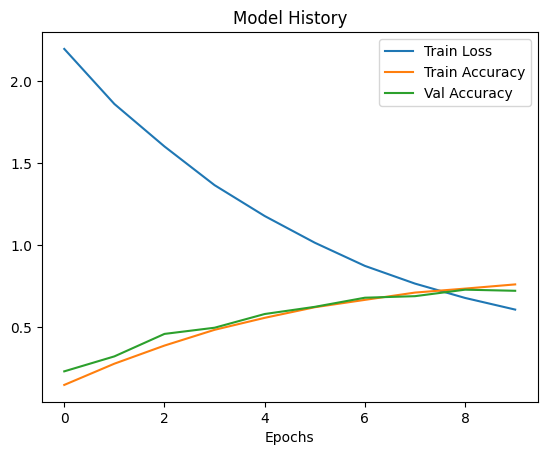

In [117]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=P2a_model.parameters(),
                            lr=0.1)
accuracy_fn = MulticlassAccuracy(num_classes=10).to(device)
epochs = 10

start_time = datetime.now()
P2a_model_history = train(model=P2a_model,
                     train_dataloader=trainLoader,
                     val_dataloader=valLoader,
                     optim=optimizer,
                     loss_fn=loss_fn,
                     accuracy_fn=accuracy_fn,
                     epochs=epochs,
                     device=device,
                     verbose=False)
stop_time = datetime.now()
print(f"Training Time: {stop_time - start_time}")
plot_history(P2a_model_history)
# Train Test 1: Training with Base version of GoogleNet was very poor, so I removed some of the Inception blocks
# Train Test 2: After removing b4, training improved while decreasing complexity. Accuracy was still low after 10 epochs

In [119]:
P2a_model(torch.randn(1, 3, 64, 64).to(device))

tensor([[ 0.1759, -3.8758,  3.2394,  1.5138,  2.8231, -0.6364,  3.9632, -2.3055,
         -2.1075, -2.6912]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
# CLEARED OUTPUT FOR SUBMISSION DUE TO LONG WARNING MESSAGE
with torch.cuda.device(0):
  macs, params = get_model_complexity_info(P2a_model, (3, 64, 64), as_strings=True,
                                           print_per_layer_stat=False, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

In [142]:
torch.save(P2a_model.state_dict(), "models/P2a")

## Problem 2b: Add Batch Normalization to previous model. Report performance and compare

In [127]:
# Redefine GoogleNet with Batch Norm
class Inception_bn(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4):
        super(Inception_bn, self).__init__()
        # Branch 1
        self.b1_1 = nn.Sequential(
            nn.LazyConv2d(c1, kernel_size=1),
            nn.LazyBatchNorm2d(),
        )
        # Branch 2
        self.b2_1 = nn.Sequential(
            nn.LazyConv2d(c2[0], kernel_size=1),
            nn.LazyBatchNorm2d()
        )
        self.b2_2 = nn.Sequential(
            nn.LazyConv2d(c2[1], kernel_size=3, padding=1),
            nn.LazyBatchNorm2d()
        )
        # Branch 3
        self.b3_1 = nn.Sequential(
            nn.LazyConv2d(c3[0], kernel_size=1),
            nn.LazyBatchNorm2d()
        )
        self.b3_2 = nn.Sequential(
            nn.LazyConv2d(c3[1], kernel_size=5, padding=2),
            nn.LazyBatchNorm2d()
        )
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.Sequential(
            nn.LazyConv2d(c4, kernel_size=1),
            nn.LazyBatchNorm2d()
        )

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

In [132]:
class GoogleNet_bn(nn.Module):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.b1 = nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.b2 = nn.Sequential(
            nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
            nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.b3 = nn.Sequential(
            Inception_bn(64, (96, 128), (16, 32), 32),
            Inception_bn(128, (128, 192), (32, 96), 64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        # self.b4 = nn.Sequential(
        #     Inception_bn(192, (96, 208), (16, 48), 64),
        #     Inception_bn(160, (112, 224), (24, 64), 64),
        #     Inception_bn(128, (128, 256), (24, 64), 64),
        #     Inception_bn(112, (144, 288), (32, 64), 64),
        #     Inception_bn(256, (160, 320), (32, 128), 128),
        #     nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # )
        self.b5 = nn.Sequential(
            Inception_bn(256, (160, 320), (32, 128), 128),
            Inception_bn(384, (192, 384), (48, 128), 128),
            nn.AdaptiveAvgPool2d((1,1)), nn.Flatten()
        )
        
        self.net = nn.Sequential(
            self.b1,
            self.b2,
            self.b3,
            # self.b4,
            self.b5,
            nn.LazyLinear(num_classes)
        )
    def forward(self, x):
        x = self.net(x)
        return x

In [134]:
P2b_model = GoogleNet_bn().to(device)
P2b_model(torch.randn(1, 3, 64, 64).to(device))

tensor([[-0.0417,  0.4391, -0.0223,  0.1302,  0.4491, -0.2250, -0.3055,  0.2199,
          0.2255,  0.0317]], device='cuda:0', grad_fn=<AddmmBackward0>)

 10%|████████▎                                                                          | 1/10 [00:40<06:02, 40.24s/it]

Epoch: 1
--------------- Train Loss: 1.4451, Train Accuracy: 0.4920, Val Loss: 1.3977, Val Accuracy: 0.5168


 20%|████████████████▌                                                                  | 2/10 [01:19<05:18, 39.86s/it]

Epoch: 2
--------------- Train Loss: 0.8906, Train Accuracy: 0.6818, Val Loss: 0.7717, Val Accuracy: 0.7111


 30%|████████████████████████▉                                                          | 3/10 [02:00<04:41, 40.15s/it]

Epoch: 3
--------------- Train Loss: 0.6857, Train Accuracy: 0.7511, Val Loss: 0.7342, Val Accuracy: 0.7293


 40%|█████████████████████████████████▏                                                 | 4/10 [02:39<03:58, 39.69s/it]

Epoch: 4
--------------- Train Loss: 0.5595, Train Accuracy: 0.7934, Val Loss: 0.6820, Val Accuracy: 0.7457


 50%|█████████████████████████████████████████▌                                         | 5/10 [03:17<03:15, 39.15s/it]

Epoch: 5
--------------- Train Loss: 0.4616, Train Accuracy: 0.8218, Val Loss: 0.7467, Val Accuracy: 0.7298


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [03:55<02:34, 38.70s/it]

Epoch: 6
--------------- Train Loss: 0.3761, Train Accuracy: 0.8510, Val Loss: 0.7209, Val Accuracy: 0.7411


 70%|██████████████████████████████████████████████████████████                         | 7/10 [04:33<01:55, 38.53s/it]

Epoch: 7
--------------- Train Loss: 0.3073, Train Accuracy: 0.8697, Val Loss: 0.7479, Val Accuracy: 0.7512


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [05:11<01:16, 38.48s/it]

Epoch: 8
--------------- Train Loss: 0.2510, Train Accuracy: 0.8895, Val Loss: 0.7450, Val Accuracy: 0.7536


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [05:50<00:38, 38.46s/it]

Epoch: 9
--------------- Train Loss: 0.2011, Train Accuracy: 0.9065, Val Loss: 0.7512, Val Accuracy: 0.7729


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [06:28<00:00, 38.85s/it]

Epoch: 10
--------------- Train Loss: 0.1630, Train Accuracy: 0.9171, Val Loss: 0.8659, Val Accuracy: 0.7641
Training Time: 0:06:28.546035


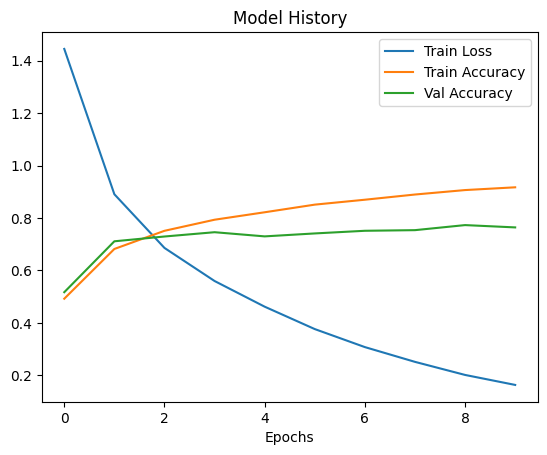

In [135]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=P2b_model.parameters(),
                            lr=0.1)
accuracy_fn = MulticlassAccuracy(num_classes=10).to(device)
epochs = 10

start_time = datetime.now()
P2b_model_history = train(model=P2b_model,
                     train_dataloader=trainLoader,
                     val_dataloader=valLoader,
                     optim=optimizer,
                     loss_fn=loss_fn,
                     accuracy_fn=accuracy_fn,
                     epochs=epochs,
                     device=device,
                     verbose=False)
stop_time = datetime.now()
print(f"Training Time: {stop_time - start_time}")
plot_history(P2b_model_history)

In [ ]:
# CLEARED OUTPUT FOR SUBMISSION DUE TO LONG WARNING MESSAGE
with torch.cuda.device(0):
  macs, params = get_model_complexity_info(P2b_model, (3, 64, 64), as_strings=True,
                                           print_per_layer_stat=False, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

In [143]:
torch.save(P2b_model.state_dict(), "models/P2b")

#### GoogleNet:

Training Time: 0:05:38.641771

Computational complexity: 222.81 MMac

Number of parameters: 2.97 M 

#### GoogleNet with Batch Norm:

Training Time: 0:06:28.546035

Computational complexity: 223.17 MMac

Number of parameters: 2.98 M 

#### Conclusions

Based on the training performed in Problem 2, we can see that adding batch normalization does not significantly change the model's complexity. With batch normalization, the validation accuracy increased by 6%.

## Problem 3a: With ResNet-18, train that for CIFAR-10 and report and compare against GoogleNet and VGGNet architectures

In [18]:
# Build ResNet version from lecture, using D2L code
class Residual(nn.Module):
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [19]:
class ResNet(nn.Module):
    def block(self, num_residuals, num_channels, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                blk.append(Residual(num_channels))
        return nn.Sequential(*blk)

    def __init__(self, arch, lr=0.1, num_classes=10, ):
        super().__init__()
        self.stem = nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.body = nn.Sequential()
        for i, b in enumerate(arch):
            self.body.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
        self.body.add_module("AVG Adaptive Pool", nn.AdaptiveAvgPool2d((1, 1)))
        
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(num_classes)
        )
        
        self.net = nn.Sequential(
            self.stem,
            self.body,
            self.head,
        )
    def forward(self, x):
        x = self.stem(x)
        x = self.body(x)
        x = self.head(x)
        return x

In [15]:
P3a_model = ResNet(((2, 64), (2, 128), (2, 256), (2, 512))).to(device)
P3a_model(torch.randn(1, 3, 64, 64).to(device))

tensor([[-0.2125, -0.5688,  0.1475,  0.6222,  0.0256, -0.4285,  0.3562, -0.0945,
          0.0902,  0.1118]], device='cuda:0', grad_fn=<AddmmBackward0>)

 10%|████████▎                                                                          | 1/10 [00:35<05:20, 35.63s/it]

Epoch: 1
--------------- Train Loss: 1.5410, Train Accuracy: 0.4345, Val Loss: 1.2523, Val Accuracy: 0.5479


 20%|████████████████▌                                                                  | 2/10 [01:10<04:42, 35.35s/it]

Epoch: 2
--------------- Train Loss: 1.0868, Train Accuracy: 0.6090, Val Loss: 1.0442, Val Accuracy: 0.6158


 30%|████████████████████████▉                                                          | 3/10 [01:45<04:05, 35.12s/it]

Epoch: 3
--------------- Train Loss: 0.8484, Train Accuracy: 0.6885, Val Loss: 0.9218, Val Accuracy: 0.6736


 40%|█████████████████████████████████▏                                                 | 4/10 [02:22<03:33, 35.61s/it]

Epoch: 4
--------------- Train Loss: 0.6743, Train Accuracy: 0.7489, Val Loss: 0.8411, Val Accuracy: 0.6869


 50%|█████████████████████████████████████████▌                                         | 5/10 [02:56<02:56, 35.23s/it]

Epoch: 5
--------------- Train Loss: 0.5299, Train Accuracy: 0.7977, Val Loss: 0.7499, Val Accuracy: 0.7256


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [03:31<02:20, 35.09s/it]

Epoch: 6
--------------- Train Loss: 0.4049, Train Accuracy: 0.8366, Val Loss: 0.7569, Val Accuracy: 0.7288


 70%|██████████████████████████████████████████████████████████                         | 7/10 [04:06<01:45, 35.10s/it]

Epoch: 7
--------------- Train Loss: 0.3029, Train Accuracy: 0.8693, Val Loss: 0.9208, Val Accuracy: 0.7049


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [04:41<01:09, 34.98s/it]

Epoch: 8
--------------- Train Loss: 0.2295, Train Accuracy: 0.8946, Val Loss: 0.8587, Val Accuracy: 0.7353


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [05:15<00:34, 34.86s/it]

Epoch: 9
--------------- Train Loss: 0.1612, Train Accuracy: 0.9149, Val Loss: 0.9522, Val Accuracy: 0.7245


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:50<00:00, 35.06s/it]

Epoch: 10
--------------- Train Loss: 0.1271, Train Accuracy: 0.9292, Val Loss: 0.9186, Val Accuracy: 0.7448
Training Time: 0:05:50.575383


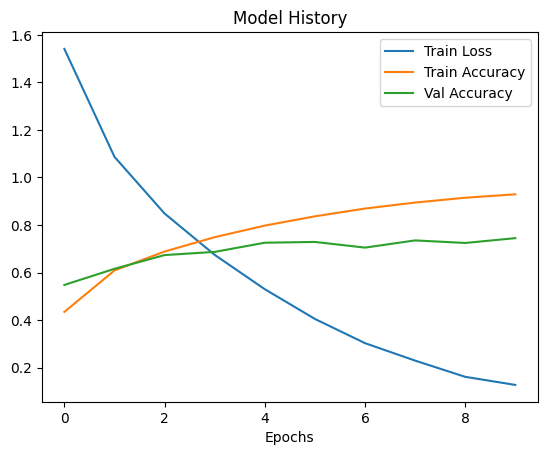

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=P3a_model.parameters(),
                            lr=0.1)
accuracy_fn = MulticlassAccuracy(num_classes=10).to(device)
epochs = 10

start_time = datetime.now()
P3a_model_history = train(model=P3a_model,
                     train_dataloader=trainLoader,
                     val_dataloader=valLoader,
                     optim=optimizer,
                     loss_fn=loss_fn,
                     accuracy_fn=accuracy_fn,
                     epochs=epochs,
                     device=device,
                     verbose=False)
stop_time = datetime.now()
print(f"Training Time: {stop_time - start_time}")
plot_history(P3a_model_history)

In [ ]:
# CLEARED OUTPUT FOR SUBMISSION DUE TO LONG WARNING MESSAGE
with torch.cuda.device(0):
  macs, params = get_model_complexity_info(P3a_model, (3, 64, 64), as_strings=True,
                                           print_per_layer_stat=False, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

## Problem 3b: Build two new versions of ResNet (ResNet-26, and ResNet-32). Train and compare with each version

In [20]:
# Construct ResNet-26
P3b_26_model = ResNet(((2, 64), (4, 128), (4, 256), (2, 512))).to(device)
P3b_26_model(torch.randn(1, 3, 64, 64).to(device))

tensor([[-0.2602, -0.1892,  0.4048,  0.0902,  0.7225,  0.2032,  0.3447,  0.6396,
         -0.2927, -0.0169]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=P3b_26_model.parameters(),
                            lr=0.1)
accuracy_fn = MulticlassAccuracy(num_classes=10).to(device)
epochs = 10

start_time = datetime.now()
P3b_26_model_history = train(model=P3b_26_model,
                     train_dataloader=trainLoader,
                     val_dataloader=valLoader,
                     optim=optimizer,
                     loss_fn=loss_fn,
                     accuracy_fn=accuracy_fn,
                     epochs=epochs,
                     device=device,
                     verbose=False)
stop_time = datetime.now()
print(f"Training Time: {stop_time - start_time}")
plot_history(P3b_26_model_history)

 10%|████████▎                                                                          | 1/10 [00:45<06:47, 45.23s/it]

Epoch: 1
--------------- Train Loss: 1.6680, Train Accuracy: 0.3848, Val Loss: 1.4122, Val Accuracy: 0.4839


 10%|████████▎                                                                          | 1/10 [00:51<07:40, 51.22s/it]


KeyboardInterrupt: 

In [ ]:
# CLEARED OUTPUT FOR SUBMISSION DUE TO LONG WARNING MESSAGE
with torch.cuda.device(0):
  macs, params = get_model_complexity_info(P3b_26_model, (3, 64, 64), as_strings=True,
                                           print_per_layer_stat=False, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

In [78]:
# Construct ResNet-32
P3b_32_model = ResNet(((2, 64), (5, 128), (5, 256), (3, 512))).to(device)
P3b_32_model(torch.randn(1, 3, 64, 64).to(device))

NameError: name 'ResNet' is not defined

 10%|████████▎                                                                          | 1/10 [00:49<07:23, 49.28s/it]

Epoch: 1
--------------- Train Loss: 1.7100, Train Accuracy: 0.3762, Val Loss: 1.7068, Val Accuracy: 0.4024


 20%|████████████████▌                                                                  | 2/10 [01:37<06:30, 48.81s/it]

Epoch: 2
--------------- Train Loss: 1.2818, Train Accuracy: 0.5309, Val Loss: 1.2083, Val Accuracy: 0.5518


 30%|████████████████████████▉                                                          | 3/10 [02:26<05:42, 48.89s/it]

Epoch: 3
--------------- Train Loss: 1.1066, Train Accuracy: 0.5963, Val Loss: 1.1232, Val Accuracy: 0.6100


 40%|█████████████████████████████████▏                                                 | 4/10 [03:15<04:52, 48.71s/it]

Epoch: 4
--------------- Train Loss: 0.8983, Train Accuracy: 0.6694, Val Loss: 0.9508, Val Accuracy: 0.6493


 50%|█████████████████████████████████████████▌                                         | 5/10 [04:03<04:03, 48.69s/it]

Epoch: 5
--------------- Train Loss: 0.7556, Train Accuracy: 0.7149, Val Loss: 0.9877, Val Accuracy: 0.6665


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [04:52<03:14, 48.67s/it]

Epoch: 6
--------------- Train Loss: 0.6243, Train Accuracy: 0.7605, Val Loss: 1.0585, Val Accuracy: 0.6863


 70%|██████████████████████████████████████████████████████████                         | 7/10 [05:41<02:26, 48.80s/it]

Epoch: 7
--------------- Train Loss: 0.5172, Train Accuracy: 0.7964, Val Loss: 1.2242, Val Accuracy: 0.7095


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [06:30<01:37, 48.76s/it]

Epoch: 8
--------------- Train Loss: 0.4084, Train Accuracy: 0.8315, Val Loss: 1.0643, Val Accuracy: 0.7019


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [07:18<00:48, 48.73s/it]

Epoch: 9
--------------- Train Loss: 0.3262, Train Accuracy: 0.8619, Val Loss: 0.9603, Val Accuracy: 0.7118


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [08:07<00:00, 48.78s/it]

Epoch: 10
--------------- Train Loss: 0.2473, Train Accuracy: 0.8859, Val Loss: 1.0491, Val Accuracy: 0.7095
Training Time: 0:08:07.774512


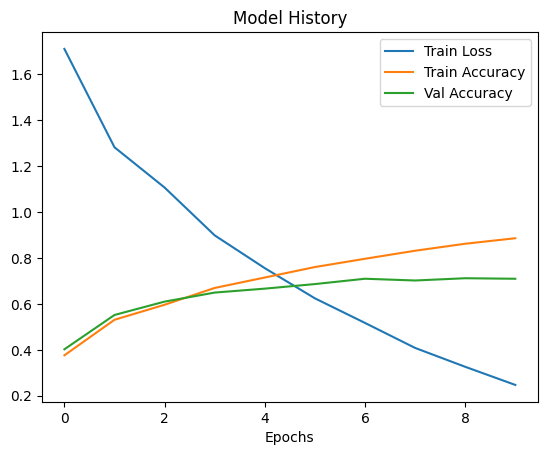

In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=P3b_32_model.parameters(),
                            lr=0.1)
accuracy_fn = MulticlassAccuracy(num_classes=10).to(device)
epochs = 10

start_time = datetime.now()
P3b_32_model_history = train(model=P3b_32_model,
                     train_dataloader=trainLoader,
                     val_dataloader=valLoader,
                     optim=optimizer,
                     loss_fn=loss_fn,
                     accuracy_fn=accuracy_fn,
                     epochs=epochs,
                     device=device,
                     verbose=False)
stop_time = datetime.now()
print(f"Training Time: {stop_time - start_time}")
plot_history(P3b_32_model_history)

In [ ]:
# CLEARED OUTPUT FOR SUBMISSION DUE TO LONG WARNING MESSAGE
with torch.cuda.device(0):
  macs, params = get_model_complexity_info(P3b_32_model, (3, 64, 64), as_strings=True,
                                           print_per_layer_stat=False, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

#### ResNet-18:

Training Time: 0:05:50.575383

Computational complexity: 297.53 MMac

Number of parameters: 11.18 M

#### ResNet-26:

Training Time: 0:07:03.636258

Computational complexity: 448.82 MMac

Number of parameters: 14.14 M 

#### ResNet-32:

Training Time: 0:08:07.774512

Computational complexity: 562.24 MMac

Number of parameters: 20.34 M 

#### Conclusions

Problem 3a: Out of three modern CNNs tested, VGG-19 performed the best with a classification accuracy of 79%. GoogleNet with batch norm was the runner up with an accuracy of 76%, with ResNet-18 trailing behind with 74%. Comparing model complexity and size, GoogleNet is more efficiently performing than the other CNNs. VGG-19 was drastically larger and more complex compared to the other models which had similar size/complexity.

Problem 3b: As ResNet became deeper, the model complexity increased as expected. The shallowest ResNet (ResNet-18) had the best accuracy with 74%. As the depth increased, the accuracy decreased. This would not have changed with more epochs as all the ResNet models began to overfit after 3 epochs.

## For Quiz Extra Credit: Create a similarly complexed DenseNet model to compare with ResNet-18

In [12]:
# Build DenseNet model from D2L textbook code
def conv_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=3, padding=1))
class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate input and output of each block along the channels
            X = torch.cat((X, Y), dim=1)
        return X
def transition_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [13]:
blk = DenseBlock(2, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

C:\Users\stanl\anaconda3\envs\pytorch_cuda\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([4, 23, 8, 8])

In [14]:
class DenseNet(nn.Module):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    def __init__(self, num_channels=64, growth_rate=32, arch=(4, 4, 4, 4),
             lr=0.1, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(self.b1())
        for i, num_convs in enumerate(arch):
            self.net.add_module(f'dense_blk{i+1}', DenseBlock(num_convs,
                                                              growth_rate))
            # The number of output channels in the previous dense block
            num_channels += num_convs * growth_rate
            # A transition layer that halves the number of channels is added
            # between the dense blocks
            if i != len(arch) - 1:
                num_channels //= 2
                self.net.add_module(f'tran_blk{i+1}', transition_block(
                    num_channels))
        self.net.add_module('last', nn.Sequential(
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.LazyLinear(num_classes))
                           )
    def forward(self, x):
        x = self.net(x)
        return x

In [22]:
# NEED TO DEBUG DENSENET MODEL, WILL SEND WHEN FINISHED
DenseNet_model = DenseNet(arch=(6, 16, 18, 24)).to(device)
DenseNet_model(torch.randn(1, 3, 64, 64).to(device))

tensor([[ 0.4171, -0.2354,  0.0058, -0.3055,  0.2153, -0.1027,  0.2784, -0.2422,
         -0.1048, -0.0803]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [23]:
# CLEARED OUTPUT FOR SUBMISSION DUE TO LONG WARNING MESSAGE
with torch.cuda.device(0):
  macs, params = get_model_complexity_info(DenseNet_model, (3, 64, 64), as_strings=True,
                                           print_per_layer_stat=False, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Computational complexity:       284.92 MMac
Number of parameters:           11.4 M  


 10%|████████▎                                                                          | 1/10 [01:21<12:11, 81.27s/it]

Epoch: 1
--------------- Train Loss: 1.5973, Train Accuracy: 0.4200, Val Loss: 1.3099, Val Accuracy: 0.5135


 20%|████████████████▌                                                                  | 2/10 [02:42<10:50, 81.29s/it]

Epoch: 2
--------------- Train Loss: 1.1371, Train Accuracy: 0.5878, Val Loss: 0.9877, Val Accuracy: 0.6281


 30%|████████████████████████▉                                                          | 3/10 [04:05<09:35, 82.20s/it]

Epoch: 3
--------------- Train Loss: 0.8866, Train Accuracy: 0.6776, Val Loss: 0.8047, Val Accuracy: 0.6954


 40%|█████████████████████████████████▏                                                 | 4/10 [05:27<08:12, 82.17s/it]

Epoch: 4
--------------- Train Loss: 0.7214, Train Accuracy: 0.7352, Val Loss: 0.8668, Val Accuracy: 0.6803


 50%|█████████████████████████████████████████▌                                         | 5/10 [06:49<06:49, 81.96s/it]

Epoch: 5
--------------- Train Loss: 0.6129, Train Accuracy: 0.7722, Val Loss: 0.7087, Val Accuracy: 0.7345


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [08:11<05:28, 82.05s/it]

Epoch: 6
--------------- Train Loss: 0.5242, Train Accuracy: 0.8013, Val Loss: 0.7083, Val Accuracy: 0.7400


 70%|██████████████████████████████████████████████████████████                         | 7/10 [09:32<04:04, 81.59s/it]

Epoch: 7
--------------- Train Loss: 0.4493, Train Accuracy: 0.8250, Val Loss: 0.6094, Val Accuracy: 0.7720


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [10:54<02:43, 81.70s/it]

Epoch: 8
--------------- Train Loss: 0.3910, Train Accuracy: 0.8491, Val Loss: 0.6320, Val Accuracy: 0.7675


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [12:18<01:22, 82.50s/it]

Epoch: 9
--------------- Train Loss: 0.3255, Train Accuracy: 0.8668, Val Loss: 0.6206, Val Accuracy: 0.7711


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [13:43<00:00, 82.37s/it]

Epoch: 10
--------------- Train Loss: 0.2770, Train Accuracy: 0.8795, Val Loss: 0.5878, Val Accuracy: 0.7910
Training Time: 0:13:43.704113


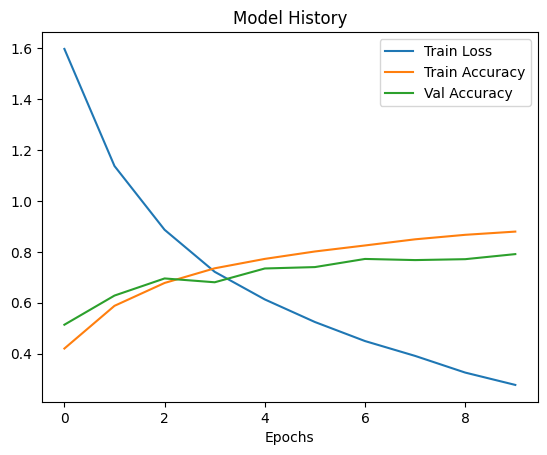

In [24]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=DenseNet_model.parameters(),
                            lr=0.1)
accuracy_fn = MulticlassAccuracy(num_classes=10).to(device)
epochs = 10

start_time = datetime.now()
DenseNet_model_history = train(model=DenseNet_model,
                     train_dataloader=trainLoader,
                     val_dataloader=valLoader,
                     optim=optimizer,
                     loss_fn=loss_fn,
                     accuracy_fn=accuracy_fn,
                     epochs=epochs,
                     device=device,
                     verbose=False)
stop_time = datetime.now()
print(f"Training Time: {stop_time - start_time}")
plot_history(DenseNet_model_history)

#### Conclusion:

Based on the below characteristics of the similarly complex models, DenseNet is able to achieve a higher validation accuracy than ResNet.

##### DenseNet:

Training Time: 0:13:43.704113

Computational complexity: 284.92 MMac

Number of parameters: 11.4 M 

Val Accuracy: 0.7910

##### ResNet-18:

Training Time: 0:05:50.575383

Computational complexity: 297.53 MMac

Number of parameters: 11.18 M

Val Accuracy: 0.74